## Statistical Inference, t-tests, and multiple comparisons

For a brief aside on t-tests and how to use them, see: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-t-values-and-t-distributions

### Multiple Comparisons in Statistical Tests

While our goal with this course is not to teach you statistics, we do need to take a slight detour to address some common statistical issues that come up in ECoG analyses. First, we'll touch on the problem of **multiple comparisons** ( https://en.wikipedia.org/wiki/Multiple_comparisons_problem ). This refers to the idea that, if you run many statistical tests, you're more likely to get a false positive with increasing numbers of tests. For example, if a subject has 100 electrodes, and we'd like to test whether there's an increase in power at each electrode, some will -- purely by chance -- show an increase in power even if it's not meaningfully correlated with memory. 

The easiest way to correct for multiple comparisons is to set a more stringent threshold for determining significance. Typically, these thresholds are set as <i>p</i> values, which you're likely quite familiar with. The <i>p</i> value is the proportion of test statistic values that, under the null hypothesis, exceed the true test statistic. If too many null values exceed the true value, it's hard to say that the true value is "significant." But if you set the <i>p</i> value to something very small -- as in, almost no null values exceed the true value -- it becomes quite difficult to find a "significant" result. 

Indeed, the **Bonferonni correction** is a common and simple way to account for the multiple comparisons problem. The basic idea is to take the <i>P</i> value you'd ordinarily use, and divide it by the number of tests you're running. So if usually you'd want a P<0.05 to declare significance, but you run 100 tests, now you'd need a P<0.0005 for significance. This is a very conservative way to control for multiple comparisons (strictly, Bonferonni correction controls for the "familywise error" rate). 

If a test survives Bonferonni correction (and assuming other assumptions about the test were also met), that's a strong indication that there's something real there (i.e. you're not looking at a false positive), and you can make some conclusions about it. Bonferonni falls under the category of **family-wise error rate (FWER) control**, or the probably that *any* test leads to a Type I (false positive) error. 

You'll also see "False Discovery Rate" controlling procedures, or **FDR correction**, in the ECoG literature. These are less conservative tests that let you screen for effects in large amounts of data, but do not offer the same kind of strict control that Bonferonni does (therefore, be more cautious in your interpretation of the "significant" effects.). A common FDR procedure is called "Benjamini-Hochberg," though there are several algorithms with unique properties. FDR correction limits the total *proportion* of Type I errors across all tests.

Many types of correction can be applied using the stats toolbox within MNE. Let's explore a few of these now, and use them on real data. 

<center>
<img src="https://github.com/esolomon/PythonBootcamp2019/blob/master/figures/fwer.png?raw=true" width=300>
<center>

In [1]:
import numpy as np
import os

# First, let's load up some data with dimensions [frequencies, electrodes, time bins].
pvals = np.load(os.path.join('sample_files','R1001P_pvals.npy'))

Text(0, 0.5, 'Count')

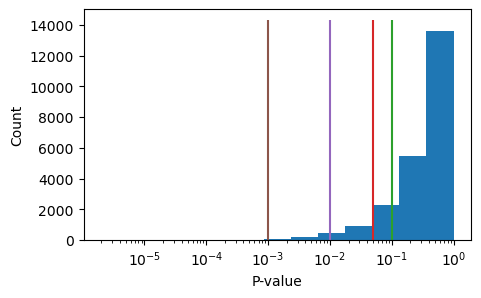

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Let's take a look at the distribution of these p-values.
# Plot a histogram of pvalues on a log scale.
plt.figure(figsize=(5, 3))
ax = plt.subplot(111)
_, bins, _ = plt.hist(pvals.ravel(), bins=13, alpha=0)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(pvals.ravel(), bins=logbins, color='C0')
plt.vlines([0.1, 0.05, 0.01, 0.001], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
       colors=('C2', 'C3', 'C4', 'C5'),)
plt.xscale('log')
plt.xlabel('P-value')
plt.ylabel('Count')

It's clear that there aren't many P-values less than 0.001. Would any of these survive Bonferonni correction?

(Perhaps testing individual P-values across all timepoints, frequencies, and electrodes isn't the best approach. What if we restricted ourselves to running tests at the electrode level, for a given time window of interest?)

In [3]:
from scipy.stats import ttest_ind,ttest_1samp,ttest_rel

# Load the raw power values so we can run some tests.
rec = np.load(os.path.join('sample_files', 'R1001P_recalled.npy'))
pows = np.load(os.path.join('sample_files', 'R1001P_pows.npy'))

# pows are dimensions [freqs, events, electrodes, time bins].

# Let's average powers into across the 400-700 ms window.
# This begins after ERP effects die out,
# but not so long as to include irrelevant activity.
# Furthermore, let's only analyze the theta frequencies,
# which were the first 5 (trust me).
avg_pow = np.mean(np.mean(pows[:5, :, :, 4:7], 0), -1)

# avg_pow should be an events X electrodes array. Excellent!
# Let's do our 2-sample T-test on these averaged values
ts, ps = ttest_ind(avg_pow[rec==1, :], avg_pow[rec==0, :], axis=0, equal_var=False)

In [7]:
ts

array([-0.3555126 ,  1.0384718 ,  0.276416  , -0.25648656,  1.5434333 ,
       -1.6623278 , -2.9956203 , -2.2204201 , -0.7788851 ,  0.13119453,
       -0.5708875 , -0.9716215 ,  3.4042187 ,  1.4167502 ,  3.2007513 ,
       -1.916248  , -0.8828504 , -2.22042   , -3.4453914 , -1.5439718 ,
       -2.6404097 ,  1.8090264 , -1.5909345 , -0.4827368 ,  1.1283836 ,
        1.6208075 , -0.8400902 , -0.73778474,  0.02045396, -0.13523813,
       -1.0821105 , -0.85651636, -1.1305807 , -0.22234446, -0.34624925,
       -1.4399501 ,  3.1252782 ,  0.6798259 , -0.09843229,  1.9514506 ,
        2.1099813 ,  0.05555366, -0.31886965, -1.5570853 , -1.8060504 ,
       -1.5774311 , -0.20341088,  0.2608621 ,  1.8214865 ,  0.00726441,
        1.4166048 , -0.2651343 , -0.42922828,  0.30815858, -2.4224308 ,
       -0.8308091 , -1.3323493 ,  0.39942074,  0.8921742 ,  3.104473  ,
        2.2625992 ,  0.7958723 ,  2.397951  ,  1.2115769 ,  1.2601931 ,
       -1.5945747 , -0.78095317, -0.6867251 , -0.5537076 ,  0.05

In [8]:
ps

array([7.2262204e-01, 3.0040094e-01, 7.8255135e-01, 7.9789186e-01,
       1.2454862e-01, 9.7687729e-02, 3.1214620e-03, 2.7713850e-02,
       4.3708295e-01, 8.9577210e-01, 5.6887311e-01, 3.3263034e-01,
       8.0576784e-04, 1.5813820e-01, 1.6032027e-03, 5.6906022e-02,
       3.7854308e-01, 2.7654728e-02, 7.0110196e-04, 1.2425044e-01,
       9.0553481e-03, 7.1892209e-02, 1.1334144e-01, 6.2984473e-01,
       2.6078346e-01, 1.0681257e-01, 4.0193647e-01, 4.6153942e-01,
       9.8370433e-01, 8.9256489e-01, 2.8046966e-01, 3.9285800e-01,
       2.5977483e-01, 8.2428092e-01, 7.2954971e-01, 1.5160604e-01,
       2.0759837e-03, 4.9749541e-01, 9.2169952e-01, 5.2621536e-02,
       3.6077306e-02, 9.5576334e-01, 7.5021166e-01, 1.2123693e-01,
       7.2655588e-02, 1.1653222e-01, 8.3905989e-01, 7.9448634e-01,
       7.0218988e-02, 9.9421191e-01, 1.5840477e-01, 7.9121548e-01,
       6.6826212e-01, 7.5830632e-01, 1.6365318e-02, 4.0712041e-01,
       1.8452877e-01, 6.9008547e-01, 3.7341928e-01, 2.2161584e

In [4]:
# If we did an uncorrected test, what would we find?
sig_elecs = ps<0.05

print(ps<0.05)

[False False False False False False  True  True False False False False
  True False  True False False  True  True False  True False False False
 False False False False False False False False False False False False
  True False False False  True False False False False False False False
 False False False False False False  True False False False False  True
  True False  True False False False False False False False False False]


In [5]:
# What about Bonferonni correction?
from mne.stats import bonferroni_correction
reject, pval_cor = bonferroni_correction(ps, 0.05)

print(reject)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


No electrodes survive Bonferroni correction! Is it too conservative? Remember that Bonferonni assume **no statistical dependency between tests.** What about FDR correction (Benjamini-Hochberg)?

In [6]:
# FDR correction
from mne.stats import fdr_correction
reject, pval_cor = fdr_correction(ps, 0.05)  #by default, this implements Benjamini-Hochberg with a 0.05 threshold. 

print(reject)

[False False False False False False  True False False False False False
  True False  True False False False  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False]


In [10]:
len(reject)*.05

3.6

A few electrodes are back! With this threshold, we would expect, on average, 5% of the significant tests to result in a Type I error. 

The significant electrodes should not be over-interpreted, since we used a less-conservative test. Some still might be false positives. But they may carry interesting signal, and combined with other information, these signals could teach us something about the brain. 